# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></div><div class="lev2 toc-item"><a href="#Initial-Thoughts" data-toc-modified-id="Initial-Thoughts-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initial Thoughts</a></div><div class="lev2 toc-item"><a href="#Initial-Exploration-&amp;-Sanity-Checks" data-toc-modified-id="Initial-Exploration-&amp;-Sanity-Checks-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Initial Exploration &amp; Sanity Checks</a></div><div class="lev3 toc-item"><a href="#Proportions-of-categorical-variables" data-toc-modified-id="Proportions-of-categorical-variables-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Proportions of categorical variables</a></div><div class="lev3 toc-item"><a href="#Sanity-check:-Random-distribution-amongst-test/control" data-toc-modified-id="Sanity-check:-Random-distribution-amongst-test/control-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Sanity check: Random distribution amongst test/control</a></div><div class="lev3 toc-item"><a href="#Sanity-check:-what-are-the-overall-conversion-rates-as-a-population?" data-toc-modified-id="Sanity-check:-what-are-the-overall-conversion-rates-as-a-population?-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Sanity check: what are the overall conversion rates as a population?</a></div><div class="lev3 toc-item"><a href="#Sanity-check:-conversion-rates-by-group?" data-toc-modified-id="Sanity-check:-conversion-rates-by-group?-124"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Sanity check: conversion rates by group?</a></div><div class="lev3 toc-item"><a href="#Quick-check:-Expected-Revenue" data-toc-modified-id="Quick-check:-Expected-Revenue-125"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Quick check: Expected Revenue</a></div><div class="lev1 toc-item"><a href="#Modelling" data-toc-modified-id="Modelling-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Modelling</a></div><div class="lev2 toc-item"><a href="#Modelling-Choices" data-toc-modified-id="Modelling-Choices-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Modelling Choices</a></div><div class="lev2 toc-item"><a href="#Model-Implementation" data-toc-modified-id="Model-Implementation-22"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model Implementation</a></div><div class="lev2 toc-item"><a href="#Model-Results" data-toc-modified-id="Model-Results-23"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Model Results</a></div><div class="lev3 toc-item"><a href="#Conversion-Rate" data-toc-modified-id="Conversion-Rate-231"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Conversion Rate</a></div><div class="lev3 toc-item"><a href="#Value-Per-Customer" data-toc-modified-id="Value-Per-Customer-232"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Value Per Customer</a></div><div class="lev2 toc-item"><a href="#Model-Interpretation" data-toc-modified-id="Model-Interpretation-24"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Model Interpretation</a></div>

In [19]:
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import patsy as ps

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction

In this notebook, we are analyzing the results of an A/B test. Personally, I don't like the specialized terminology, so I'm going to refer to this test as a "control-vs-test" experiment. 

The control group was exposed to one price of the software (\$39), and the test group was exposed to the other price of the software (\$59). 

The goal of this analysis is to see whether increasing the price might increase revenue.

Let's take a look at the data provided. Firstly, we have the `test_results.csv` file.

In [4]:
results_df = pd.read_csv('data/test_results.csv')
results_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


## Initial Thoughts

Some initial thoughts about the contents of `test_results.csv`. 

1. The most important columns are "`test`" (correlated with "`price`"), and "`converted`", which is "whether the customer bought the software or not". 
1. There may be a confounding factor beyond price, which includes iOS, device, and source. I'm not sure which yet, but we can model it.

## Initial Exploration & Sanity Checks

To get a feel for the data, let's do some exploratory analysis.

### Proportions of categorical variables

Let's first plot the proportions of each categorical variable: `source`, `device`, `operative_system`.

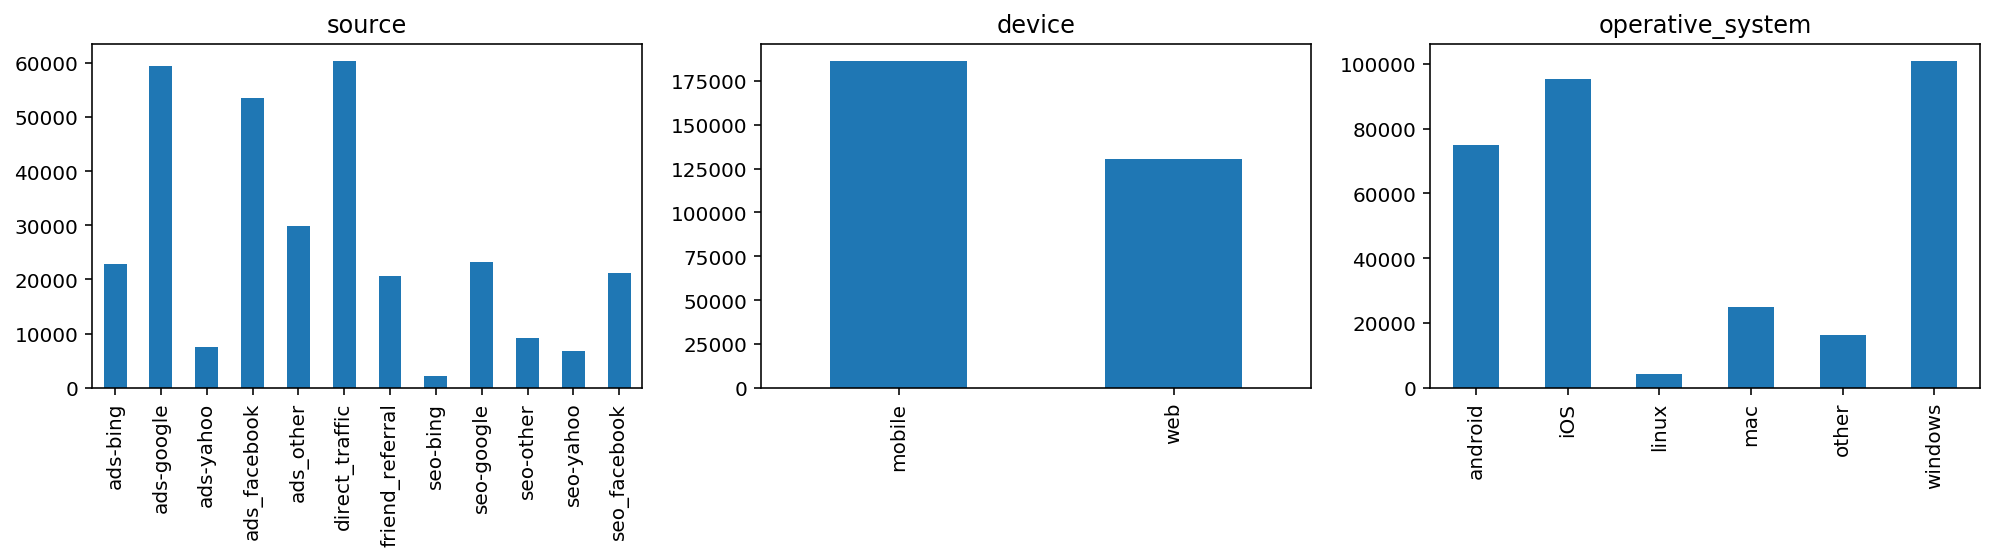

In [36]:
fig = plt.figure(figsize=(14,4))

gs = GridSpec(nrows=1, ncols=3)
factors = ['source', 'device', 'operative_system']

for i, factor in enumerate(factors):
    ax = fig.add_subplot(gs[i])
    results_df.groupby(factor).count()['converted'].plot(kind='bar', ax=ax)
    ax.set_xlabel('')
    ax.set_title(factor)

plt.tight_layout()

### Sanity check: Random distribution amongst test/control

Before we go on, we know that the test groups were randomly split into 66% control, 33% test, which is roughly 2:1. Let's make sure that these proportions are maintained when we look at each grouping of the data.

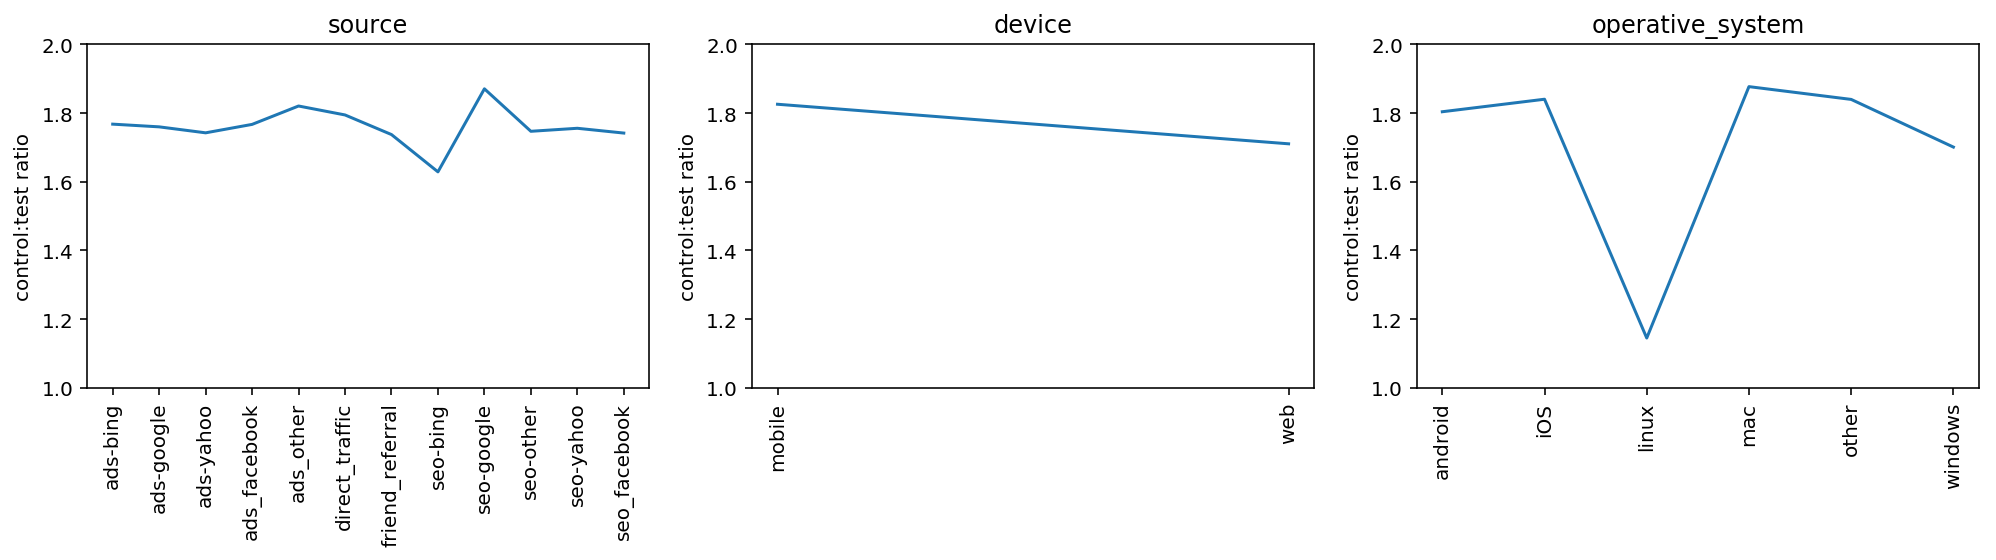

In [37]:
fig = plt.figure(figsize=(14,4))
gs = GridSpec(1, 3)
for i, factor in enumerate(factors):
    ax = fig.add_subplot(gs[i])
    data = []
    grps = []
    for g, d in results_df.groupby(factor):
        n_control = len(d[d['test'] == 0])
        n_test = len(d[d['test'] == 1])

        grps.append(g)
        data.append(n_control/n_test)        
    ax.plot(range(len(grps)), data)
    ax.set_xticks(range(len(grps)))
    ax.set_xticklabels(grps, rotation=90)
    ax.set_ylim(1, 2)
    ax.set_ylabel('control:test ratio')
    ax.set_title(factor)
plt.tight_layout()

From this analysis, we see that the group `linux` has the lowest control:test ratio. All other grouping of the data more or less preserves the control/test ratio of ~1.8, which is close enough for our purposes.

I don't think I'll be necessary to exclude the Linux group. My initial thoughts right now are that if we use a hierarchical Bayesian model, we can pool together the groups somehow and the effect of imbalanced control vs. test group might be mitigated.

### Sanity check: what are the overall conversion rates as a population?

In [42]:
conv_rate_population = \
    len(results_df[results_df['converted'] == 1]) / len(results_df)
conv_rate_population

0.018333333333333333

The conversion rate of {{ conv_rate_population }} is very low. The vast majority of people don't buy software.

### Sanity check: conversion rates by group?

In [48]:
is_test = (results_df['test'] == 1)
is_ctrl = (results_df['test'] == 0)

is_conv = (results_df['converted'] == 1)

n_test = len(results_df[is_test])
n_ctrl = len(results_df[is_ctrl])

test_conv = results_df[is_test & is_conv]
ctrl_conv = results_df[is_ctrl & is_conv]

ctrl_rate = len(ctrl_conv)/n_ctrl
test_rate = len(test_conv)/n_test

Here's a summary of the data.

In the control group, we have {{ n_ctrl }} samples taken, {{ len(ctrl_conv) }} conversions, giving a {{ ctrl_rate * 100 }}% conversion rate.

In the test group, we have {{ n_test }} samples taken, {{ len(test_conv) }} conversions, giving a {{ test_rate * 100 }}% conversion rate.

At first glance, it may seem like we don't want to increase the price, so let's quickly check whether total revenue is impacted.

### Quick check: Expected Revenue

In [49]:
test_revenue = test_rate * 59
ctrl_revenue = ctrl_rate * 39

Expected test group revenue is \${{ test_revenue }} per user.

Expected control group revenue is \${{ ctrl_revenue }} per user.

# Modelling

We are going to do some modelling using PyMC3 to figure out whether we expect more revenue from the \$59 price group compared to the \$39 price group.

## Modelling Choices

Firstly, we have 1 vs. 0 for the outcome for each group. Let's do the simple thing by assuming that the $ p $ for each group, $ p_{test} $ and $ p_{ctrl} $ are estimated independently, and that they're not drawn from some common pool like it might be estimated in a hierarchical model.

Secondly, let's estimate the uncertainty around $ p_{test} $ and $ p_{ctrl} $, and deterministically figure out the uncertainty in the expected revenue.

Thirdly, let's place uninformative Uniform priors on $ p_{test} $ and $ p_{ctrl} $, because indeed I didn't know anything about each $ p $ before seeing the data.

## Model Implementation

Here, I implement the model in PyMC3.

In [57]:
with pm.Model() as model:
    p_test = pm.Uniform('p_test', 0, 1)
    p_ctrl = pm.Uniform('p_ctrl', 0, 1)
    
    like_test = pm.Bernoulli('like_test', 
                             p=p_test, 
                             observed=results_df[is_test]['converted'].values)
    like_ctrl = pm.Bernoulli('like_ctrl', 
                             p=p_ctrl,
                             observed=results_df[is_ctrl]['converted'].values)
    
    test_dollar = pm.Deterministic('test_dollar', p_test * 59)
    ctrl_dollar = pm.Deterministic('ctrl_dollar', p_ctrl * 39)

In [58]:
with model:
    trace = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -67,362:  11%|█▏        | 22556/200000 [00:46<06:02, 489.87it/s]Median ELBO converged.
Finished [100%]: Average ELBO = -45,612

100%|██████████| 2000/2000 [00:24<00:00, 81.11it/s]


## Model Results

Let's take a look at the results.

### Conversion Rate

Firstly, let's look at the posterior distribution of the values of `p_test` and `p_ctrl`, which are the conversion rates for the test and control groups respectively.

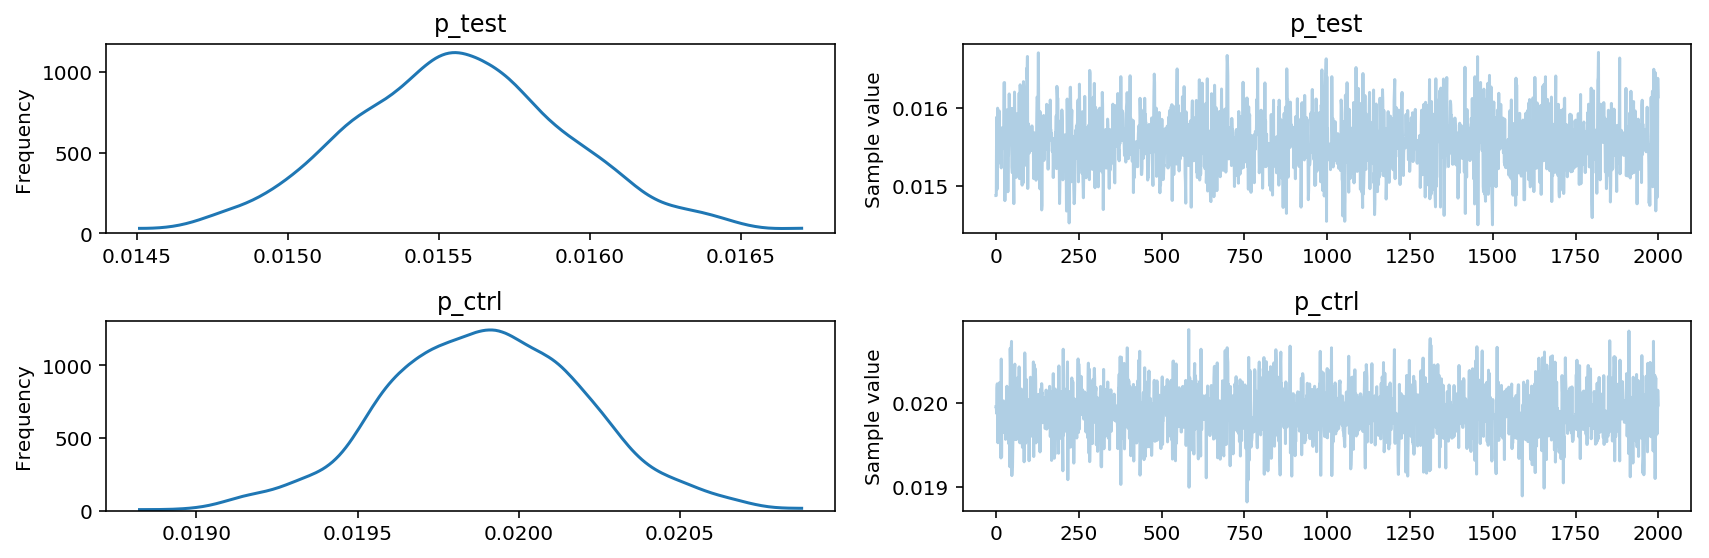

In [80]:
pm.traceplot(trace, varnames=['p_test', 'p_ctrl'])
plt.show()

### Value Per Customer

Next, let's look at the posterior distributions of the expected income per customer.

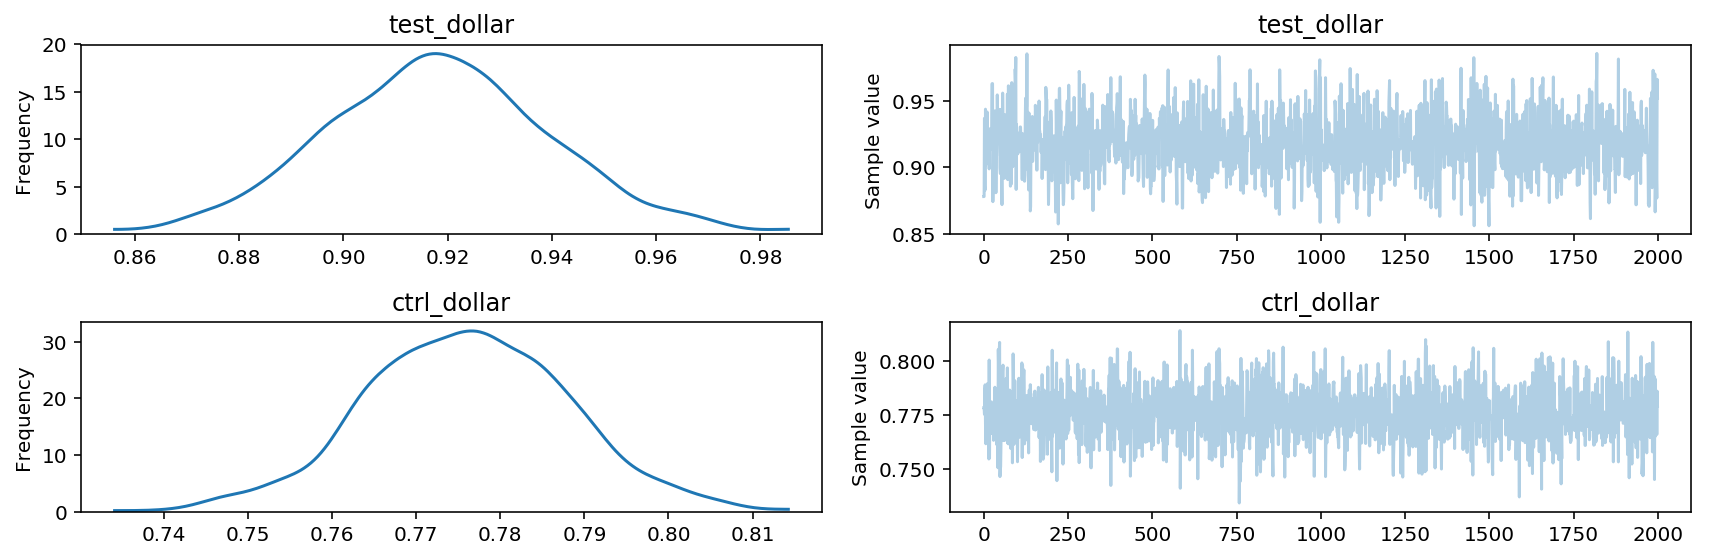

In [84]:
pm.traceplot(trace, varnames=['test_dollar', 'ctrl_dollar'])
plt.show()

We can also look at the posterior distribution summary.

In [85]:
pm.summary(trace, varnames=['test_dollar', 'ctrl_dollar'])


test_dollar:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.918            0.022            0.001            [0.872, 0.959]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.875          0.904          0.917          0.932          0.963


ctrl_dollar:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.776            0.012            0.000            [0.753, 0.801]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.752          0.768          0.776          0.784          0.800



In [81]:
# Percentiles
t_lower, t_med, t_upper = np.round(
    np.percentile(trace['test_dollar'], [2.5, 50, 97.5]), 2)
c_lower, c_med, c_upper = np.round(
    np.percentile(trace['ctrl_dollar'], [2.5, 50, 97.5]), 2)

In [82]:
c_med

0.78000000000000003

## Model Interpretation

Without the price increase, each customer is expected to yield \${{ c_med }}, with a lower bound of \${{ c_lower }} and an upper bound of \${{ c_upper }}.

With the price increase, each customer is expected to yield \${{ t_med }}, with a lower bound of \${{ t_lower }} and an upper bound of \${{ t_upper }}.

The two distributions do not overlap, meaning that we have a high probability of increasing revenue on a per-customer basis.